Key points and explanation:

The dataset contains 552 features and 2000 observations. Data types for the columns are as follows: Float64 (444), int64 (105), object(3)

Data types
- There are 3 features with datatype = object. Converted 2 to numeric variables by mapping with appropriate numbers. The third has been removed as it had 83 unique string entries

- First column is the target property, data type is float64

Null Values
- A total of 100 entries have null values (all of them belong to a single feature - "MW2"). Since this accounts for 5% of the total records, they can be removed. Another option is mean/median imputation. In this assignment, I have replaced null values with the column mean

- MW2 column had 100 observations with string "Computation failed". The rest were integers. Replaced the string with NaN abd subsequently with the mean.

Outliers
- Definition of outliers: Values < 5th Percentile and Values > 95th Percentile. Although this definition assumes that the distribution is normal when in reality it might not be

- Replaced outliers in the lower bound with the 5th Percentile value and outliers in the upper bound by 95th Percentile values. Essentially, I have capped the minimum and maximum values

Correlation
- Correlation of features with the target variable: Majority of the features, i.e. approximately 80% have between 0-0.2 (absolute values) correlation with the target variable. This number is quite large with many features in the same range. Thus, eliminating low correlation features is difficult and by doing so we might lose out on important information even if it does not seem relevant at this time. For this reason, I have not dropped any features due to low correlation with the target variable

- Correlation amongst features: Used the pearson correlation to evaluate correlation of features with each other. Features with high correlation with each other (>0.975) are excluded since they will not help in improving results of our model due to being highly correlated with another feature. This leaves us with 233 features.

PCA
- Standardized the data, converted to between -1 and 1 to prevent bias towards larger value features
- Performed PCA on the processed dataset and obtained the final 2D plot. PC 1 accounts for ~14% variance and PC 2 for ~9%. 50 components account for ~90% of the variance.

- Observations from the PCA plot: The clusters are not very distinct, shows the dataset is very complex. Will need to do further processing by using other non-dimensionality reduction methods


Non-linear dimensionality reduction
- Performed UMAP reduction. Still not clear enough, although better than the PCA plot. 
- Tried with the standard default parameters. Also modified them to explore if other values give better results
- Combining PCA and non-dimensionality



In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
df = pd.read_csv(r"C:\Users\kantg\OneDrive\Desktop\CMU\ML for Science\Lab 1\lab1_dataset.csv") # Loading the csv file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 552 entries, experimental_proprty to n6Ring
dtypes: float64(444), int64(105), object(3)
memory usage: 8.4+ MB


count    2000.000000
mean        2.170570
std         1.207616
min        -1.500000
25%         1.370000
50%         2.340000
75%         3.100000
max         4.500000
Name: experimental_proprty, dtype: float64


C:\Users\kantg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='experimental_proprty'>

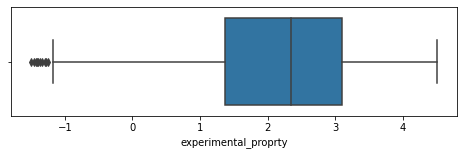

In [216]:
# Looking at the target property
print(df['experimental_proprty'].describe())

fig = plt.figure(figsize =(8, 2)) # Box plot
sns.boxplot(df['experimental_proprty'])


In [202]:
## Null values

print(df.isna().sum().sum()) # No. of observations with null values
df.columns[df.isna().any()].tolist() # list columns with nulls
print(df['MW2'].info()) # Check data type - it's float, can impute with mean/median since it's a small number
mean_MW2 = df['MW2'].mean()
df['MW2'].fillna(value = mean_MW2, inplace=True) # Mean imputation

100
<class 'pandas.core.series.Series'>
RangeIndex: 2000 entries, 0 to 1999
Series name: MW2
Non-Null Count  Dtype  
--------------  -----  
1900 non-null   float64
dtypes: float64(1)
memory usage: 15.8 KB
None


In [203]:
# Categorical variables
print(df.select_dtypes(include=['object']).columns.tolist())

c1 = df['MS_enc'].nunique()
c2 = df['MIF'].nunique()
c3 = df['SMIF'].nunique()
print(c1,c2,c3)
#print(df['MS_enc'].unique())
#print(df['MIF'].unique())
#print(df['SMIF'].unique())


# Out of the 3 categorical variables, converted 2 variables to numeric variables
df = df.drop(columns = ['MS_enc'])
df['MIF'] = pd.to_numeric(df['MIF'],errors='coerce') # Str to numeric. "Computation failed" string records converted to NaN
df['MIF'].fillna(value = df['MIF'].mean(), inplace = True) # Mean imputation for NaN
df['SMIF'].replace(to_replace = ['big', 'bigger','the_biggest'], value = [1, 2, 3], inplace=True) #Replaced with int


df['MIF'].info()
df['SMIF'].info()

['MS_enc', 'MIF', 'SMIF']
51 85 3
<class 'pandas.core.series.Series'>
RangeIndex: 2000 entries, 0 to 1999
Series name: MIF
Non-Null Count  Dtype  
--------------  -----  
2000 non-null   float64
dtypes: float64(1)
memory usage: 15.8 KB
<class 'pandas.core.series.Series'>
RangeIndex: 2000 entries, 0 to 1999
Series name: SMIF
Non-Null Count  Dtype
--------------  -----
2000 non-null   int64
dtypes: int64(1)
memory usage: 15.8 KB


In [204]:
print(df.isna().sum().sum())

0


experimental_proprty    1.0
Name: experimental_proprty, dtype: float64

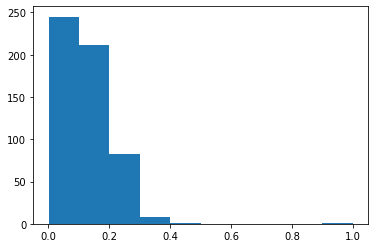

In [205]:
# Finding correlation of attributes with experimental_proprty, plot histogram
corr_exp_property = df.corr().abs()
plt.hist(corr_exp_property[['experimental_proprty']],bins=10)
corr_exp_property['experimental_proprty'].loc[corr_exp_property ['experimental_proprty'] > 0.5] # Find attributes with correlation greater than 0.5.
## only 1 - proprty itself
### For majority it's between 0 and 0.2.

In [206]:
# Capped outliers with 5%, 95% lower and upper bounds respectively

def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.05,0.95]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

df =cap_data(df)

capping the  experimental_proprty
capping the  nHetero
capping the  nX


C:\Users\kantg\AppData\Local\Temp\ipykernel_19748\2822627457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
C:\Users\kantg\AppData\Local\Temp\ipykernel_19748\2822627457.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] >= percentiles[1]] = percentiles[1]


capping the  C2SP3
capping the  MPC5
capping the  ATS0i
capping the  NaasN
capping the  SsCH3
capping the  nCl
capping the  nFAHRing
capping the  SlogP_VSA6
capping the  AATS3d
capping the  ATSC6are
capping the  nHBDon
capping the  SddssS
capping the  ATS6m
capping the  nAcid
capping the  PEOE_VSA8
capping the  SsssCH
capping the  ATSC5dv
capping the  MPC9
capping the  SsBr
capping the  MPC4
capping the  AATS5v
capping the  ZMIC1
capping the  C2SP2
capping the  ATSC8v
capping the  MW2
capping the  MIC5
capping the  SMR_VSA2
capping the  nBondsA
capping the  Xp-7d
capping the  ATS8Z
capping the  nBondsKD
capping the  ATS1dv
capping the  SaasN
capping the  PEOE_VSA6
capping the  LabuteASA
capping the  AATS5pe
capping the  ATS3pe
capping the  n9FaRing
capping the  SssS
capping the  ATS0se
capping the  MPC7
capping the  AATSC5m
capping the  EState_VSA6
capping the  SRW04
capping the  SRW03
capping the  AATS5i
capping the  n5HRing
capping the  NaaN
capping the  AATS1Z
capping the  Sse
cappi

capping the  MWC09
capping the  ATSC1p
capping the  ATSC6p
capping the  ATSC3m
capping the  NaasC
capping the  ATS4Z
capping the  ATS0p
capping the  Radius
capping the  n6HRing
capping the  nARing
capping the  PEOE_VSA9
capping the  piPC10
capping the  ATSC2m
capping the  SssssC
capping the  NaaCH
capping the  C3SP3
capping the  EState_VSA7
capping the  ATS3dv
capping the  MPC3
capping the  ATS5p
capping the  SLogP
capping the  ATSC0se
capping the  ATSC7Z
capping the  n6AHRing
capping the  SaaaC
capping the  ATS5d
capping the  MIC0
capping the  PEOE_VSA7
capping the  nRot
capping the  StCH
capping the  ATSC2v
capping the  EState_VSA10
capping the  AATS0are
capping the  ATSC7m
capping the  AATS0i
capping the  ATS7p
capping the  nBondsD
capping the  nFHRing
capping the  ATSC1are
capping the  SMR_VSA1
capping the  TIC1
capping the  Xp-4d
capping the  nAtom
capping the  ATSC3dv
capping the  C3SP2
capping the  ATS6Z
capping the  n6ARing
capping the  MPC8
capping the  ATSC4se
capping the  Ns

In [207]:
# Dropping features that have a high correlation with each other

corr_matrix = df.corr().abs() # Create correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # Select upper triangle of corr matrix
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)] # Find features with corr greater than 0.95
df.drop(to_drop, axis=1, inplace=True)# Drop features
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 234 entries, experimental_proprty to n6Ring
dtypes: float64(176), int64(58)
memory usage: 3.6 MB
None


In [208]:
## PCA --- Principal Component Analysis

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df)

df_scaled = pd.DataFrame(scaler.transform(df),columns= df.columns, index = df.index) 

X = df_scaled.drop(columns = ['experimental_proprty']) # Exclude target variable

from sklearn.decomposition import PCA
pca = PCA(n_components = 5)

pca_function = pca.fit_transform(X)
pca_df = pd.DataFrame(data = pca_function, columns = ['PC 1', 'PC 2','PC 3','PC 4','PC 5'])

# Explained variance ratio
explained_variance_ratio = list(pca.explained_variance_ratio_)
explained_variance_ratio


[0.14669698653838334,
 0.09751968961083936,
 0.06617228794519463,
 0.06013468326367926,
 0.048240397036789805]

In [209]:
## Add the target variable to the plot
pca_target = pca_df.join(df_scaled['experimental_proprty'])


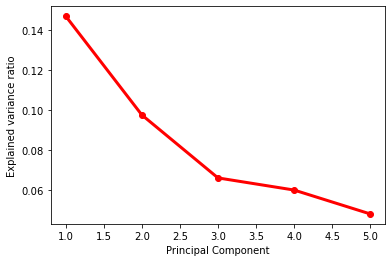

In [210]:
## Plot the graph

# Scree plot
PC_values = np.arange(pca.n_components_) + 1
fig1 = plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=3, color='red')
plt.xlabel('Principal Component')
plt.ylabel('Explained variance ratio')
plt.show()

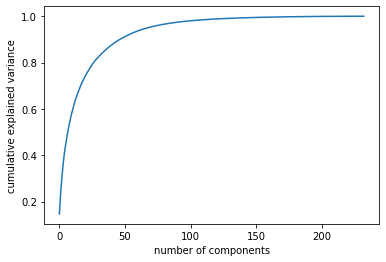

In [211]:
pca_plot = PCA().fit(X)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

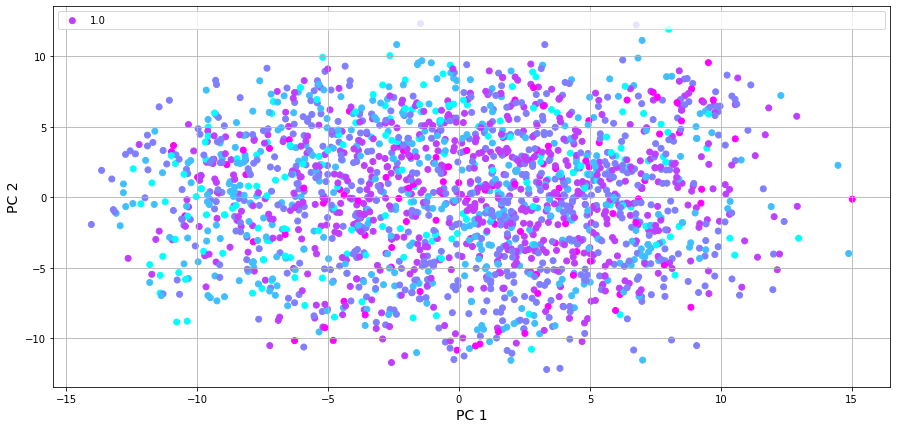

In [212]:
# Scatterplot ----- very difficult to identify clusters

fig = plt.figure(figsize = (15,7))
axis = fig.add_subplot(1,1,1) 
axis.set_xlabel('PC 1', fontsize = 14)
axis.set_ylabel('PC 2', fontsize = 14)
target = round(pca_target['experimental_proprty'])
axis.scatter(pca_target['PC 1'], pca_target['PC 2'], c=list(target) ,cmap='cool')
plt.grid()
plt.legend(list(target), loc = 9, mode = 'expand', ncol=5)
plt.show()

<AxesSubplot:>

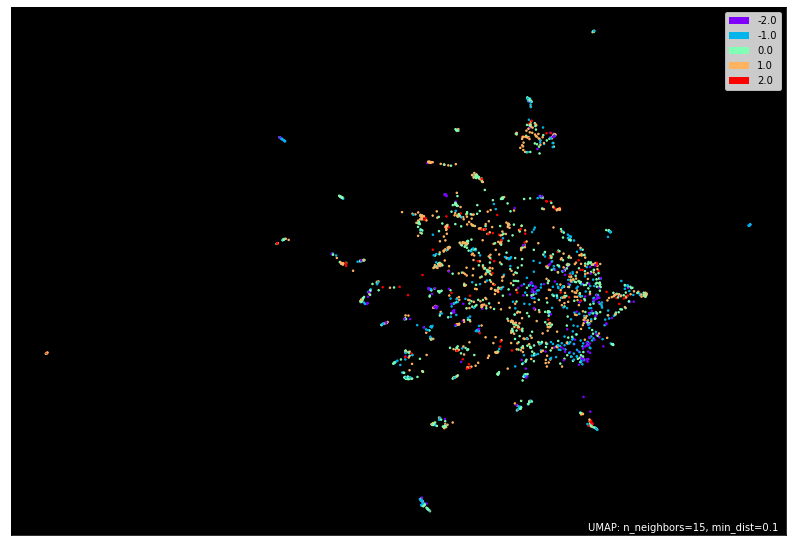

In [213]:
## Non-linear dimensionality reduction- UMAP with the default parameters

mapper = umap.UMAP().fit(df_scaled)
import umap.plot
umap.plot.points(mapper , labels = target, theme='fire', width = 1000, height = 700 )


<AxesSubplot:>

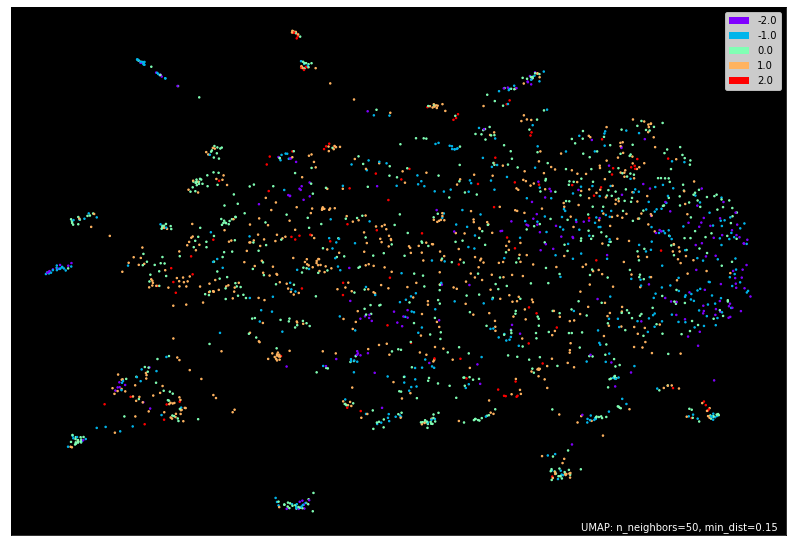

In [214]:
## Changing parameters to see how the graph varies

mapper_1 = umap.UMAP(n_neighbors=50, min_dist= 0.15).fit(df_scaled)
import umap.plot
umap.plot.points(mapper_1 , labels = target, theme='fire', width = 1000, height = 700 )